In [69]:
import nltk
import ssl
import pandas as pd
from operator import itemgetter
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import string
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

In [70]:
train = pd.read_csv('Corona_NLP_train.csv',encoding='latin-1',usecols=['OriginalTweet','Sentiment'])
test = pd.read_csv('Corona_NLP_test.csv',encoding='latin-1',usecols=['OriginalTweet','Sentiment'])

In [71]:
train.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [72]:
# A
# Pre-processing data

for row in range(len(train)):
    if train.at[row,"Sentiment"] == "Extremely Negative":
        train.at[row,"Sentiment"] = "Negative"
    elif train.at[row,"Sentiment"] == "Extremely Positive":
        train.at[row,"Sentiment"] = "Positive"
    elif train.at[row,"Sentiment"] == "Neutral":
        train = train.drop(row)
        
for row in range(len(test)):
    if test.at[row,"Sentiment"] == "Extremely Negative":
        test.at[row,"Sentiment"] = "Negative"
    elif test.at[row,"Sentiment"] == "Extremely Positive":
        test.at[row,"Sentiment"] = "Positive"
    elif test.at[row,"Sentiment"] == "Neutral":
        test = test.drop(row)

In [73]:
# Check and reset indices
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
train.head()

,OriginalTweet,Sentiment
0,advice Talk to your neighbours family to excha...,Positive
1,Coronavirus Australia: Woolworths to give elde...,Positive
2,My food stock is not the only one which is emp...,Positive
3,"Me, ready to go at supermarket during the #COV...",Negative
4,As news of the regionÂs first confirmed COVID...,Positive


In [74]:
train.describe()

,OriginalTweet,Sentiment
count,33444,33444
unique,33444,2
top,advice Talk to your neighbours family to excha...,Positive
freq,1,18046


In [75]:
# B
# Need to remove URLS and numbers using regex
# Sub from when we see https until the next space. Needs to be https followed by maybe :, ;, ''
# \S matches any char that is not whitespace
# \d+ matches digits

for row in range(len(train)):
    train.at[row,"OriginalTweet"] = re.sub(r'https?\S+', '',   train.at[row,"OriginalTweet"])
    train.at[row,"OriginalTweet"] = re.sub(r'\d+', '',   train.at[row,"OriginalTweet"])
        
for row in range(len(test)):
    test.at[row,"OriginalTweet"] = re.sub(r'https?:\S+', '',   test.at[row,"OriginalTweet"])
    test.at[row,"OriginalTweet"] = re.sub(r'\d+', '',   test.at[row,"OriginalTweet"])

In [76]:
# C tokenize

for row in range(len(train)):
    train.at[row,"OriginalTweet"] = nltk.word_tokenize(train.at[row,"OriginalTweet"])

for row in range(len(test)):
    test.at[row,"OriginalTweet"] = nltk.word_tokenize(test.at[row,"OriginalTweet"])

In [77]:
print(train.at[1,"OriginalTweet"][1])

Australia


In [78]:
# turn to lowercase

for row in range(len(train)):
    for word in range(len(train.at[row,"OriginalTweet"])):
        train.at[row,"OriginalTweet"][word] =  (train.at[row,"OriginalTweet"][word]).lower()
            
for row in range(len(test)):
    for word in range(len(test.at[row,"OriginalTweet"])):
        test.at[row,"OriginalTweet"][word] =  (test.at[row,"OriginalTweet"][word]).lower()

In [79]:
train.head()

,OriginalTweet,Sentiment
0,"[advice, talk, to, your, neighbours, family, t...",Positive
1,"[coronavirus, australia, :, woolworths, to, gi...",Positive
2,"[my, food, stock, is, not, the, only, one, whi...",Positive
3,"[me, ,, ready, to, go, at, supermarket, during...",Negative
4,"[as, news, of, the, regionâs, first, confirme...",Positive


In [80]:
# D, remove stopwords, punctuation, stem words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

for row in range(len(train)):
    train.at[row,"OriginalTweet"] = [word for word in train.at[row,"OriginalTweet"] if word not in stop_words and word not in string.punctuation]
    for word in range(len(train.at[row,"OriginalTweet"])):
        train.at[row,"OriginalTweet"][word] = nltk.PorterStemmer().stem(train.at[row,"OriginalTweet"][word])

for row in range(len(test)):
    test.at[row,"OriginalTweet"] = [word for word in test.at[row,"OriginalTweet"] if word not in stop_words and word not in string.punctuation]
    for word in range(len(test.at[row,"OriginalTweet"])):
        test.at[row,"OriginalTweet"][word] = nltk.PorterStemmer().stem(test.at[row,"OriginalTweet"][word])

In [81]:
# E,F combine the sets to get BoW

corpus = []

for row in range(len(train)):
    corpus.append(" ".join(train.at[row,"OriginalTweet"]))
    
for row in range(len(test)):
    corpus.append(" ".join(test.at[row,"OriginalTweet"]))

In [82]:
# G
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer=None, stop_words=None)

BoW = vectorizer.fit_transform(corpus)
X_train = BoW[:len(train)]
X_test = BoW[len(train):]

Y_train = train["Sentiment"].values
Y_test = test["Sentiment"].values

In [85]:
# G, Train model
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

MultinomialNB()

In [86]:
# H, Evaluate
from sklearn import metrics
predictions = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(predictions, Y_test)

In [87]:
print("The accuracy of the model is: " + str(accuracy_score))

The accuracy of the model is: 0.780119534444794


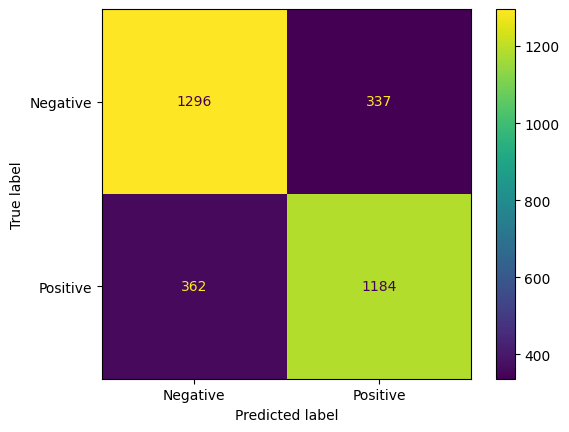

In [88]:
# Confusion Matrix, I
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, predictions, labels=MNB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=MNB.classes_)
disp.plot()

plt.show()

In [89]:
# J, precision, recall, and F1 on the positive class
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(Y_test, predictions, average=None, labels=['Positive'])

(array([0.77843524]), array([0.76584735]), array([0.77208999]), array([1546]))

In [91]:
# k, Logistic Regression
from sklearn.linear_model import LogisticRegression

# fit the model
LogRegr = LogisticRegression()
LogRegr.fit(X_train, Y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [92]:
# evaluate
predictions = LogRegr.predict(X_test)
accuracy_score = metrics.accuracy_score(predictions, Y_test)

In [93]:
print("The accuracy of the model is: " + str(accuracy_score))

The accuracy of the model is: 0.8530984586347908


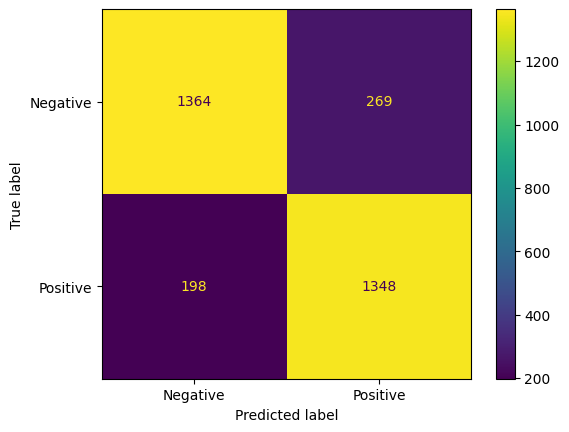

In [94]:
cm = confusion_matrix(Y_test, predictions, labels=LogRegr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LogRegr.classes_)
disp.plot()

plt.show()